In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import *
from dateutil.relativedelta import *
import os
from collections import Counter
from scipy.stats import sem, t
from scipy.stats import entropy
import seaborn as sns
import ast

In [2]:
step_size = 2
OUTPUT_BASE_PATH = '../outputs'

date_rec_added = pd.to_datetime('2011-09-15')
date_rec_added - pd.to_timedelta('1W')

popular_metrics_path = f'{OUTPUT_BASE_PATH}/plots/popular/{step_size}step_metrics.csv'
implicitmf_metrics_path = f'{OUTPUT_BASE_PATH}/plots/implicitmf/{step_size}step_metrics.csv'
itemknn_metrics_path = f'{OUTPUT_BASE_PATH}/plots/itemknn/{step_size}step_metrics.csv'
bpr_metrics_path = f'{OUTPUT_BASE_PATH}/plots/bpr/{step_size}step_metrics.csv'

popular_metrics= pd.read_csv(popular_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

implicitmf_metrics= pd.read_csv(implicitmf_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})

itemknn_metrics= pd.read_csv(itemknn_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})
bpr_metrics= pd.read_csv(bpr_metrics_path, parse_dates=[0, 1], converters={'gender_prop':ast.literal_eval,
                                                                                   'gender_prop_binary':ast.literal_eval})
popular_metrics.head()

,start_date,end_date,ndcg,ndcg_ci,rbp,rbp_ci,reciprank,reciprank_ci,gini,gini_exposure,entropy_val,gender_prop,gender_prop_binary,unique_user_train,unique_item_train,unique_user_test,unique_item_test,unique_item_recs_frac,unique_item_recs
0,2007-01-01,2009-03-01,0.046808,0.001360,0.022760,0.001139,0.058333,0.002482,0.999500,0.867473,2.931084,"{'male': 0.33580130894445376, 'female': 0.1579...","{'male': 0.6801677781630059, 'female': 0.31983...",35856,225487,17877,86231,0.000182,326
1,2007-03-01,2009-05-01,0.044152,0.001293,0.022587,0.001124,0.055180,0.002323,0.999536,0.867604,2.957494,"{'male': 0.3456953431632545, 'female': 0.15804...","{'male': 0.6862606567854387, 'female': 0.31373...",40946,244506,18854,89239,0.000178,336
2,2007-05-01,2009-07-01,0.045553,0.001333,0.024584,0.001131,0.063307,0.002512,0.999561,0.861586,2.971848,"{'male': 0.35048079246194735, 'female': 0.1651...","{'male': 0.6797476765228768, 'female': 0.32025...",45418,261494,20695,89907,0.000162,336
3,2007-07-01,2009-09-01,0.047307,0.001261,0.024892,0.001070,0.064691,0.002394,0.999580,0.856667,2.937341,"{'male': 0.34027782623866015, 'female': 0.1798...","{'male': 0.6541977160614428, 'female': 0.34580...",50348,276333,22928,93333,0.000149,341
4,2007-09-01,2009-11-01,0.037107,0.001109,0.017726,0.000873,0.047782,0.001995,0.999595,0.855162,2.925988,"{'male': 0.3368572666233485, 'female': 0.17957...","{'male': 0.6522727444298029, 'female': 0.34772...",55800,290400,23085,91142,0.000154,355


### Let's plot the metrics across all three algorithms:

Here is some basic metrics:

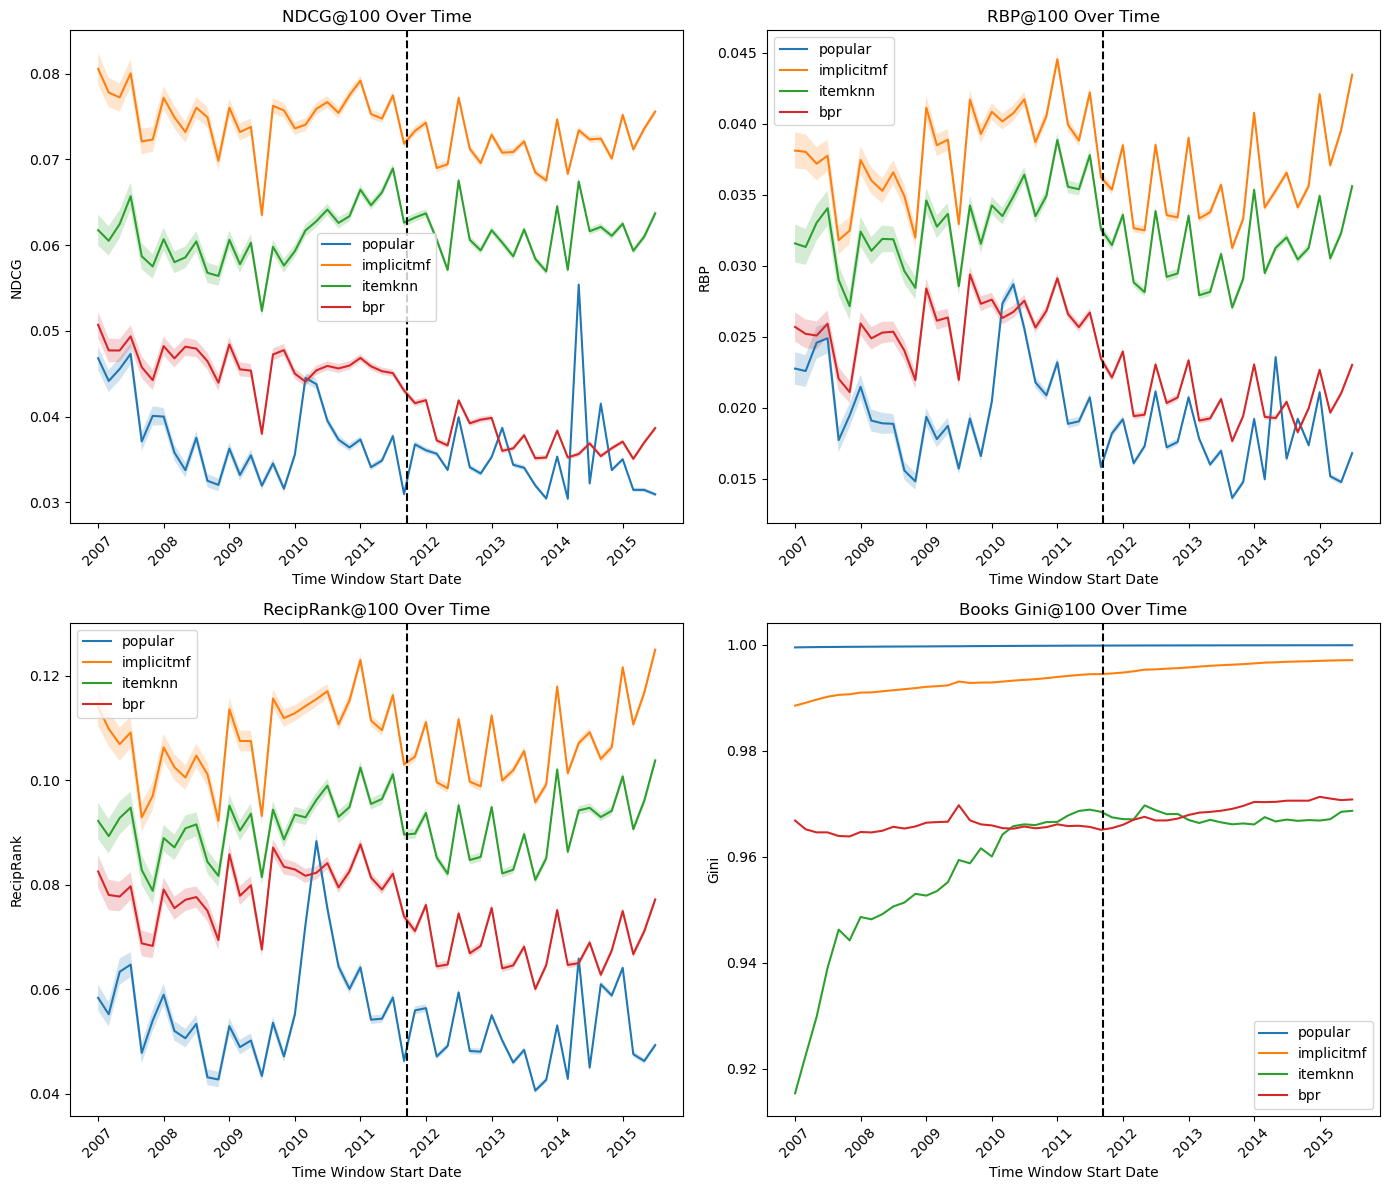

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12)) 
    
ax1.plot(popular_metrics['start_date'], popular_metrics['ndcg'], label='popular')  
ax1.fill_between(popular_metrics['start_date'],
                   popular_metrics['ndcg'] - popular_metrics['ndcg_ci'],
                   popular_metrics['ndcg'] + popular_metrics['ndcg_ci'],
                   alpha=0.2)

ax1.plot(implicitmf_metrics['start_date'], implicitmf_metrics['ndcg'], label='implicitmf')  
ax1.fill_between(implicitmf_metrics['start_date'],
                   implicitmf_metrics['ndcg'] - implicitmf_metrics['ndcg_ci'],
                   implicitmf_metrics['ndcg'] + implicitmf_metrics['ndcg_ci'],
                   alpha=0.2)

ax1.plot(itemknn_metrics['start_date'], itemknn_metrics['ndcg'], label='itemknn')  
ax1.fill_between(itemknn_metrics['start_date'],
                   itemknn_metrics['ndcg'] - itemknn_metrics['ndcg_ci'],
                   itemknn_metrics['ndcg'] + itemknn_metrics['ndcg_ci'],
                   alpha=0.2)

ax1.plot(bpr_metrics['start_date'], bpr_metrics['ndcg'], label='bpr')  
ax1.fill_between(bpr_metrics['start_date'],
                   bpr_metrics['ndcg'] - bpr_metrics['ndcg_ci'],
                   bpr_metrics['ndcg'] + bpr_metrics['ndcg_ci'],
                   alpha=0.2)

ax1.axvline(date_rec_added, color='black', linestyle='--')
ax1.set_title("NDCG@100 Over Time")
ax1.set_xlabel("Time Window Start Date")
ax1.set_ylabel("NDCG")
ax1.tick_params(axis='x', rotation=45)
ax1.legend()


# RBP    
ax2.plot(popular_metrics['start_date'], popular_metrics['rbp'], label='popular') 
ax2.fill_between(popular_metrics['start_date'],
                    popular_metrics['rbp'] - popular_metrics['rbp_ci'],
                    popular_metrics['rbp'] + popular_metrics['rbp_ci'],
                    alpha=0.2)
ax2.plot(implicitmf_metrics['start_date'], implicitmf_metrics['rbp'], label='implicitmf') 
ax2.fill_between(implicitmf_metrics['start_date'],
                    implicitmf_metrics['rbp'] - implicitmf_metrics['rbp_ci'],
                    implicitmf_metrics['rbp'] + implicitmf_metrics['rbp_ci'],
                    alpha=0.2)
ax2.plot(itemknn_metrics['start_date'], itemknn_metrics['rbp'], label='itemknn') 
ax2.fill_between(itemknn_metrics['start_date'],
                    itemknn_metrics['rbp'] - itemknn_metrics['rbp_ci'],
                    itemknn_metrics['rbp'] + itemknn_metrics['rbp_ci'],
                    alpha=0.2)
ax2.plot(bpr_metrics['start_date'], bpr_metrics['rbp'], label='bpr') 
ax2.fill_between(bpr_metrics['start_date'],
                    bpr_metrics['rbp'] - bpr_metrics['rbp_ci'],
                    bpr_metrics['rbp'] + bpr_metrics['rbp_ci'],
                    alpha=0.2)
         
ax2.axvline(date_rec_added, color='black', linestyle='--')
ax2.set_title("RBP@100 Over Time")
ax2.set_xlabel("Time Window Start Date")
ax2.set_ylabel("RBP")
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

#reciprank 
ax3.plot(popular_metrics['start_date'], popular_metrics['reciprank'], label='popular') 
ax3.fill_between(popular_metrics['start_date'],
                    popular_metrics['reciprank'] - popular_metrics['reciprank_ci'],
                    popular_metrics['reciprank'] + popular_metrics['reciprank_ci'],
                    alpha=0.2)
ax3.plot(implicitmf_metrics['start_date'], implicitmf_metrics['reciprank'], label='implicitmf') 
ax3.fill_between(implicitmf_metrics['start_date'],
                    implicitmf_metrics['reciprank'] - implicitmf_metrics['reciprank_ci'],
                    implicitmf_metrics['reciprank'] + implicitmf_metrics['reciprank_ci'],
                    alpha=0.2)
ax3.plot(itemknn_metrics['start_date'], itemknn_metrics['reciprank'], label='itemknn') 
ax3.fill_between(itemknn_metrics['start_date'],
                    itemknn_metrics['reciprank'] - itemknn_metrics['reciprank_ci'],
                    itemknn_metrics['reciprank'] + itemknn_metrics['reciprank_ci'],
                    alpha=0.2)
ax3.plot(bpr_metrics['start_date'], bpr_metrics['reciprank'], label='bpr') 
ax3.fill_between(bpr_metrics['start_date'],
                    bpr_metrics['reciprank'] - bpr_metrics['reciprank_ci'],
                    bpr_metrics['reciprank'] + bpr_metrics['reciprank_ci'],
                    alpha=0.2)

ax3.axvline(date_rec_added, color='black', linestyle='--')
ax3.set_title("RecipRank@100 Over Time")
ax3.set_xlabel("Time Window Start Date")
ax3.set_ylabel("RecipRank")
ax3.tick_params(axis='x', rotation=45)
ax3.legend()

# Books Gini
ax4.plot(popular_metrics['start_date'], popular_metrics['gini'], label='popular') 
ax4.plot(implicitmf_metrics['start_date'], implicitmf_metrics['gini'], label='implicitmf') 
ax4.plot(itemknn_metrics['start_date'], itemknn_metrics['gini'], label='itemknn') 
ax4.plot(bpr_metrics['start_date'], bpr_metrics['gini'], label='bpr') 

ax4.axvline(date_rec_added, color='black', linestyle='--')
ax4.set_title("Books Gini@100 Over Time")
ax4.set_xlabel("Time Window Start Date")
ax4.set_ylabel("Gini")
ax4.tick_params(axis='x', rotation=45)
ax4.legend()
         

plt.tight_layout() 
plt.show()

In [7]:
# unfold gender data for popular
gender_popular = popular_metrics['gender_prop'].apply(pd.Series)
gender_binary_popular = popular_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_popular.columns = ['male_binary', 'female_binary']

gender_df_popular = pd.concat([popular_metrics, gender_popular, gender_binary_popular], axis=1)

# unfold gender data for implicitmf
gender_implicitmf = implicitmf_metrics['gender_prop'].apply(pd.Series)
gender_binary_implicitmf = implicitmf_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_implicitmf.columns = ['male_binary', 'female_binary']

gender_df_implicitmf = pd.concat([implicitmf_metrics, gender_implicitmf, gender_binary_implicitmf], axis=1)

# unfold gender data for itemknn
gender_itemknn = itemknn_metrics['gender_prop'].apply(pd.Series)
gender_binary_itemknn = itemknn_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_itemknn.columns = ['male_binary', 'female_binary']

gender_df_itemknn = pd.concat([itemknn_metrics, gender_itemknn, gender_binary_itemknn], axis=1)

# unfold gender data for bpr
gender_bpr = bpr_metrics['gender_prop'].apply(pd.Series)
gender_binary_bpr = bpr_metrics['gender_prop_binary'].apply(pd.Series)
gender_binary_bpr.columns = ['male_binary', 'female_binary']

gender_df_bpr = pd.concat([bpr_metrics, gender_bpr, gender_binary_bpr], axis=1)

gender_df_itemknn.head()


,start_date,end_date,ndcg,ndcg_ci,rbp,rbp_ci,reciprank,reciprank_ci,gini,gini_exposure,...,unique_user_train,unique_item_train,unique_user_test,unique_item_test,unique_item_recs_frac,unique_item_recs,male,female,male_binary,female_binary
0,2007-01-01,2009-03-01,0.061744,0.001819,0.031571,0.001325,0.092196,0.003464,0.915392,0.881821,...,35856,225487,17877,86231,0.062871,112275,0.379645,0.272540,0.582112,0.417888
1,2007-03-01,2009-05-01,0.060500,0.001710,0.031324,0.001270,0.089272,0.003285,0.922567,0.885751,...,40946,244506,18854,89239,0.061601,116000,0.373782,0.273348,0.577599,0.422401
2,2007-05-01,2009-07-01,0.062446,0.001631,0.033027,0.001260,0.092751,0.003192,0.929812,0.892461,...,45418,261494,20695,89907,0.057951,119884,0.365955,0.270137,0.575317,0.424683
3,2007-07-01,2009-09-01,0.065693,0.001601,0.034053,0.001227,0.094723,0.003062,0.939049,0.899076,...,50348,276333,22928,93333,0.052954,121349,0.360275,0.266870,0.574468,0.425532
4,2007-09-01,2009-11-01,0.058694,0.001535,0.028993,0.001097,0.082800,0.002851,0.946267,0.903442,...,55800,290400,23085,91142,0.051166,118065,0.353539,0.266639,0.570061,0.429939


Let's look at gender distribution over time

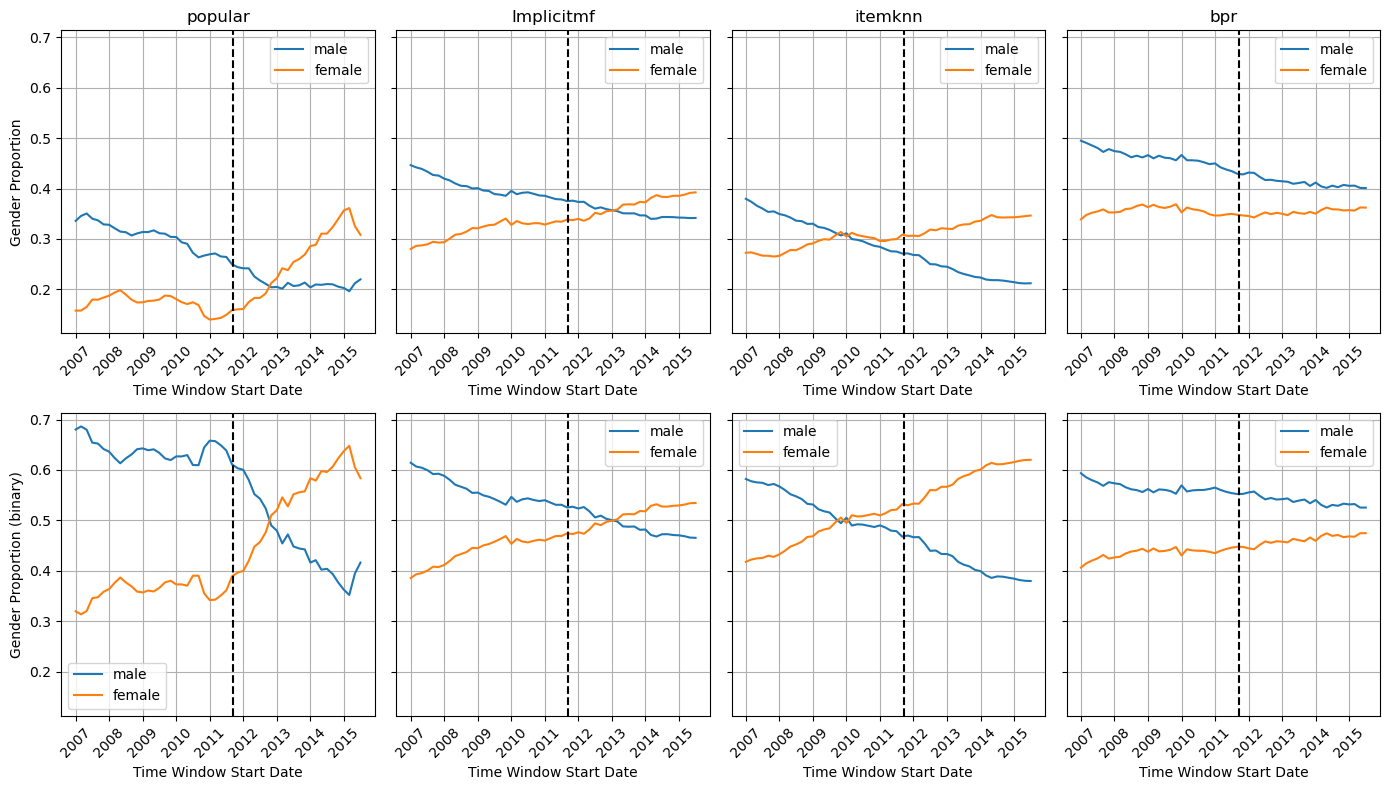

In [8]:
rows = 2
columns = 4

fig, axes = plt.subplots(rows, columns, figsize=(14, 8), sharey=True)

axes[0,0].plot(gender_df_popular['start_date'], gender_df_popular['male'], label='male')
axes[0,0].plot(gender_df_popular['start_date'], gender_df_popular['female'], label='female')
axes[0,0].axvline(date_rec_added, color='black', linestyle='--')
axes[0,0].set_title("popular")
axes[0,0].set_xlabel("Time Window Start Date")
axes[0,0].set_ylabel("Gender Proportion")
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['male'], label='male')
axes[0,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['female'], label='female')
axes[0,1].axvline(date_rec_added, color='black', linestyle='--')
axes[0,1].set_title("Implicitmf")
axes[0,1].set_xlabel("Time Window Start Date")
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()
axes[0,1].grid(True)

axes[0,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['male'], label='male')
axes[0,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['female'], label='female')
axes[0,2].axvline(date_rec_added, color='black', linestyle='--')
axes[0,2].set_title("itemknn")
axes[0,2].set_xlabel("Time Window Start Date")
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].legend()
axes[0,2].grid(True)

axes[0,3].plot(gender_df_bpr['start_date'], gender_df_bpr['male'], label='male')
axes[0,3].plot(gender_df_bpr['start_date'], gender_df_bpr['female'], label='female')
axes[0,3].axvline(date_rec_added, color='black', linestyle='--')
axes[0,3].set_title("bpr")
axes[0,3].set_xlabel("Time Window Start Date")
axes[0,3].tick_params(axis='x', rotation=45)
axes[0,3].legend()
axes[0,3].grid(True)


#gender binary (unknown genders excluded)
axes[1,0].plot(gender_df_popular['start_date'], gender_df_popular['male_binary'], label='male')
axes[1,0].plot(gender_df_popular['start_date'], gender_df_popular['female_binary'], label='female')
axes[1,0].axvline(date_rec_added, color='black', linestyle='--')
axes[1,0].set_xlabel("Time Window Start Date")
axes[1,0].set_ylabel("Gender Proportion (binary)")
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['male_binary'], label='male')
axes[1,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['female_binary'], label='female')
axes[1,1].axvline(date_rec_added, color='black', linestyle='--')
axes[1,1].set_xlabel("Time Window Start Date")
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()
axes[1,1].grid(True)

axes[1,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['male_binary'], label='male')
axes[1,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['female_binary'], label='female')
axes[1,2].axvline(date_rec_added, color='black', linestyle='--')
axes[1,2].set_xlabel("Time Window Start Date")
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].legend()
axes[1,2].grid(True)

axes[1,3].plot(gender_df_bpr['start_date'], gender_df_bpr['male_binary'], label='male')
axes[1,3].plot(gender_df_bpr['start_date'], gender_df_bpr['female_binary'], label='female')
axes[1,3].axvline(date_rec_added, color='black', linestyle='--')
axes[1,3].set_xlabel("Time Window Start Date")
axes[1,3].tick_params(axis='x', rotation=45)
axes[1,3].legend()
axes[1,3].grid(True)

plt.tight_layout()
plt.show()

Let's look at unique count of entities.

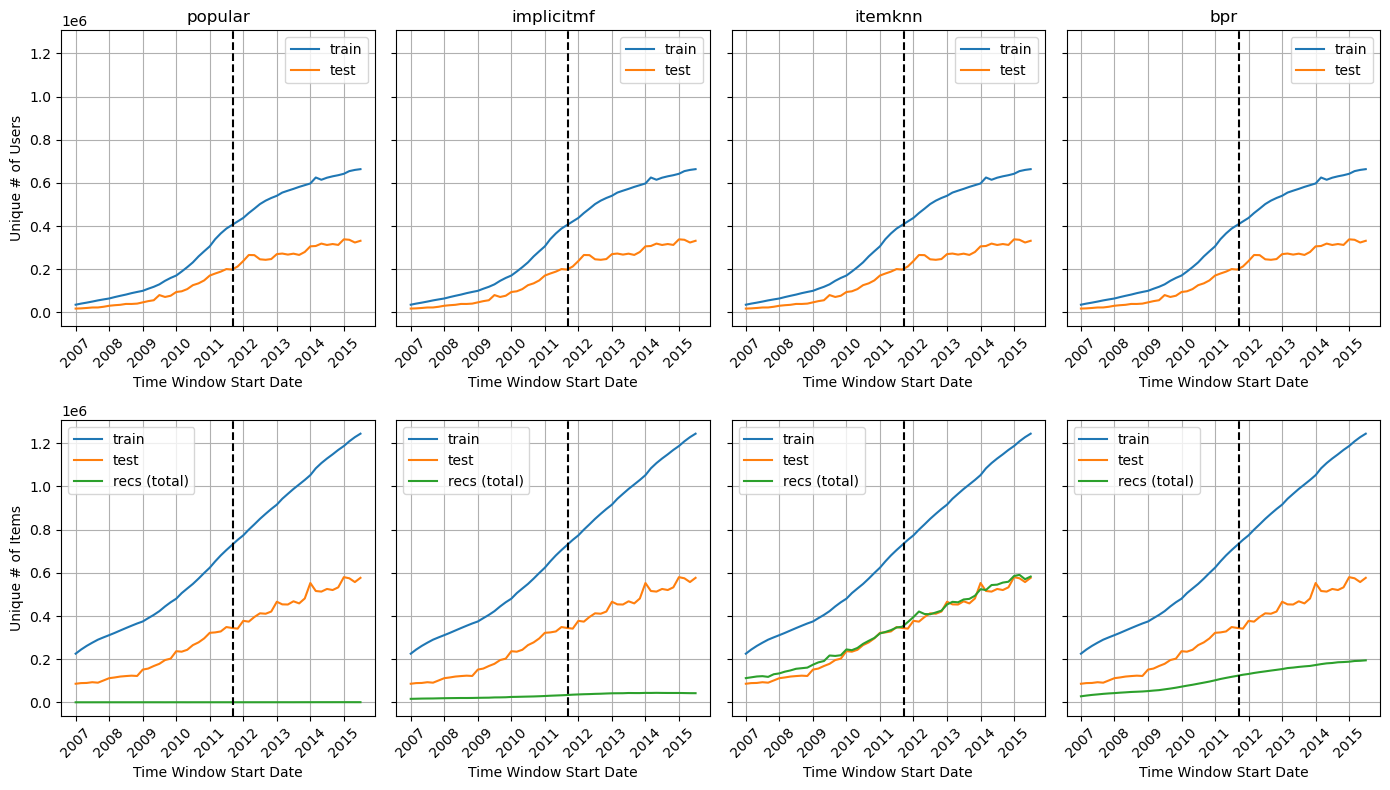

In [9]:
rows = 2
columns = 4

fig, axes = plt.subplots(rows, columns, figsize=(14, 8), sharey=True)


# unique number of users
axes[0,0].plot(gender_df_popular['start_date'], gender_df_popular['unique_user_train'], label='train')
axes[0,0].plot(gender_df_popular['start_date'], gender_df_popular['unique_user_test'], label='test')
axes[0,0].axvline(date_rec_added, color='black', linestyle='--')
axes[0,0].set_title("popular")
axes[0,0].set_xlabel("Time Window Start Date")
axes[0,0].set_ylabel("Unique # of Users")
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['unique_user_train'], label='train')
axes[0,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['unique_user_test'], label='test')
axes[0,1].axvline(date_rec_added, color='black', linestyle='--')
axes[0,1].set_title("implicitmf")
axes[0,1].set_xlabel("Time Window Start Date")
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()
axes[0,1].grid(True)

axes[0,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['unique_user_train'], label='train')
axes[0,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['unique_user_test'], label='test')
axes[0,2].axvline(date_rec_added, color='black', linestyle='--')
axes[0,2].set_title("itemknn")
axes[0,2].set_xlabel("Time Window Start Date")
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].legend()
axes[0,2].grid(True)

axes[0,3].plot(gender_df_bpr['start_date'], gender_df_bpr['unique_user_train'], label='train')
axes[0,3].plot(gender_df_bpr['start_date'], gender_df_bpr['unique_user_test'], label='test')
axes[0,3].axvline(date_rec_added, color='black', linestyle='--')
axes[0,3].set_title("bpr")
axes[0,3].set_xlabel("Time Window Start Date")
axes[0,3].tick_params(axis='x', rotation=45)
axes[0,3].legend()
axes[0,3].grid(True)


#unique number of items
axes[1,0].plot(gender_df_popular['start_date'], gender_df_popular['unique_item_train'], label='train')
axes[1,0].plot(gender_df_popular['start_date'], gender_df_popular['unique_item_test'], label='test')
axes[1,0].plot(gender_df_popular['start_date'], gender_df_popular['unique_item_recs'], label='recs (total)')
axes[1,0].axvline(date_rec_added, color='black', linestyle='--')
axes[1,0].set_xlabel("Time Window Start Date")
axes[1,0].set_ylabel("Unique # of Items")
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['unique_item_train'], label='train')
axes[1,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['unique_item_test'], label='test')
axes[1,1].plot(gender_df_implicitmf['start_date'], gender_df_implicitmf['unique_item_recs'], label='recs (total)')
axes[1,1].axvline(date_rec_added, color='black', linestyle='--')
axes[1,1].set_xlabel("Time Window Start Date")
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend()
axes[1,1].grid(True)

axes[1,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['unique_item_train'], label='train')
axes[1,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['unique_item_test'], label='test')
axes[1,2].plot(gender_df_itemknn['start_date'], gender_df_itemknn['unique_item_recs'], label='recs (total)')
axes[1,2].axvline(date_rec_added, color='black', linestyle='--')
axes[1,2].set_xlabel("Time Window Start Date")
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].legend()
axes[1,2].grid(True)

axes[1,3].plot(gender_df_bpr['start_date'], gender_df_bpr['unique_item_train'], label='train')
axes[1,3].plot(gender_df_bpr['start_date'], gender_df_bpr['unique_item_test'], label='test')
axes[1,3].plot(gender_df_bpr['start_date'], gender_df_bpr['unique_item_recs'], label='recs (total)')
axes[1,3].axvline(date_rec_added, color='black', linestyle='--')
axes[1,3].set_xlabel("Time Window Start Date")
axes[1,3].tick_params(axis='x', rotation=45)
axes[1,3].legend()
axes[1,3].grid(True)

plt.tight_layout()
plt.show()

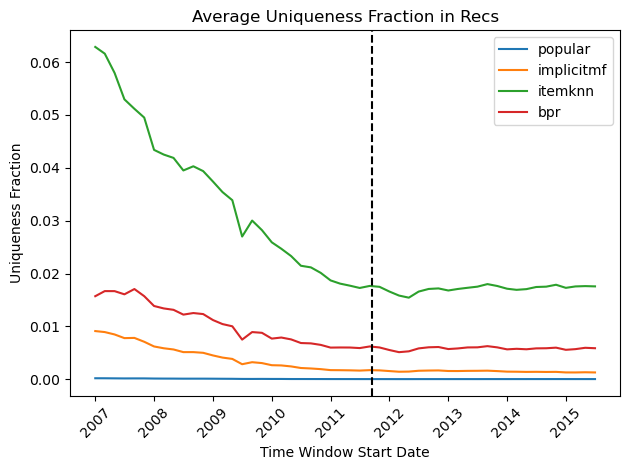

In [16]:
# Average Uniqueness Fraction in Recs (# unique items / # of spots)
fig, ax = plt.subplots()

ax.plot(popular_metrics['start_date'], popular_metrics['unique_item_recs_frac'], label='popular') 
ax.plot(implicitmf_metrics['start_date'], implicitmf_metrics['unique_item_recs_frac'], label='implicitmf') 
ax.plot(itemknn_metrics['start_date'], itemknn_metrics['unique_item_recs_frac'], label='itemknn') 
ax.plot(bpr_metrics['start_date'], bpr_metrics['unique_item_recs_frac'], label='bpr') 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Average Uniqueness Fraction in Recs")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Uniqueness Fraction")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()  
plt.show()

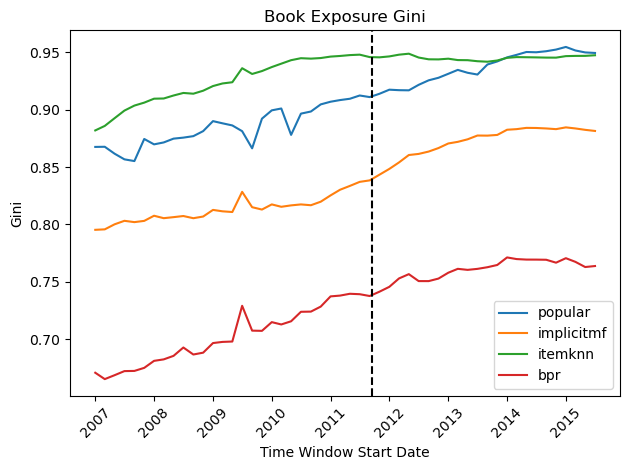

In [14]:
# Exposure gini
fig, ax = plt.subplots()

ax.plot(popular_metrics['start_date'], popular_metrics['gini_exposure'], label='popular') 
ax.plot(implicitmf_metrics['start_date'], implicitmf_metrics['gini_exposure'], label='implicitmf') 
ax.plot(itemknn_metrics['start_date'], itemknn_metrics['gini_exposure'], label='itemknn') 
ax.plot(bpr_metrics['start_date'], bpr_metrics['gini_exposure'], label='bpr') 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Book Exposure Gini")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Gini")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()  
plt.show()

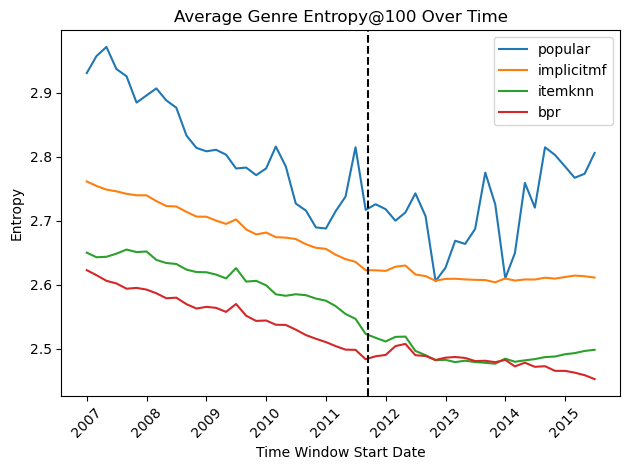

In [15]:
# genre entropy
fig, ax = plt.subplots()

ax.plot(popular_metrics['start_date'], popular_metrics['entropy_val'], label='popular') 
ax.plot(implicitmf_metrics['start_date'], implicitmf_metrics['entropy_val'], label='implicitmf') 
ax.plot(itemknn_metrics['start_date'], itemknn_metrics['entropy_val'], label='itemknn') 
ax.plot(bpr_metrics['start_date'], bpr_metrics['entropy_val'], label='bpr') 

ax.axvline(date_rec_added, color='black', linestyle='--')
ax.set_title("Average Genre Entropy@100 Over Time")
ax.set_xlabel("Time Window Start Date")
ax.set_ylabel("Entropy")
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()  
plt.show()